In [1]:
from data_processing import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
import numpy as np
from noise import NoiseScheduler
import torch
from jet_finding import find_local_maxima

testEvent=0


In [2]:
baseDir='/hdfs/user/ys20884/hackathon/data'
dataset = Dataset(1_000, (120, 72), signal_file=f"{baseDir}/CaloImages_signal.root", pile_up_file=f"{baseDir}/CaloImages_bkg.root", save=False)

In [3]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_signal.root
100%|██████████| 1000/1000 [00:24<00:00, 40.14it/s] 
INFO:root:loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
loading file /hdfs/user/ys20884/hackathon/data/CaloImages_bkg.root
100%|██████████| 1000/1000 [00:06<00:00, 166.54it/s]


In [105]:
new_dim=(64,64)

dataset.preprocess(16, new_dim)

INFO:root:scaling
scaling
INFO:root:re-sizing
re-sizing


In [106]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

In [107]:
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)

In [108]:
noise_scheduler = NoiseScheduler('pile-up')
timestep = torch.LongTensor([40]) #each unit of timestep represents an addtional 5 pile-up events
random_seed = 42
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[testEvent], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)


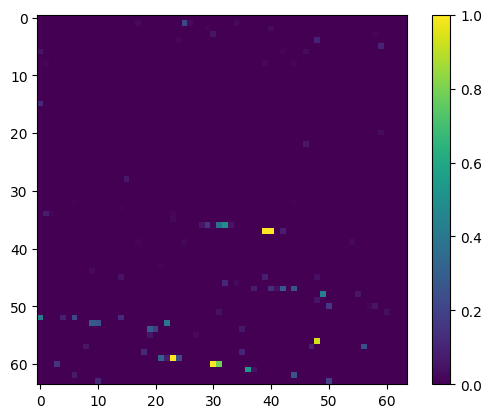

In [109]:
plt.imshow(clean_frames[testEvent].reshape(new_dim))
plt.colorbar()


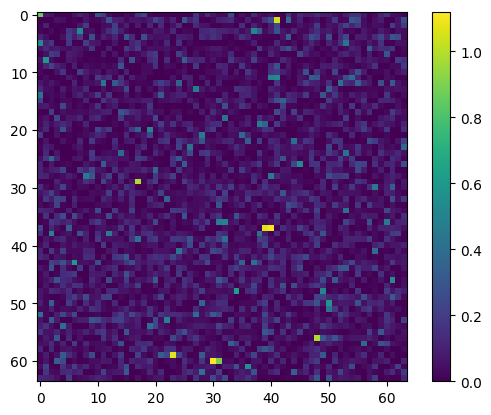

In [110]:
plt.imshow(noisy_image.reshape(new_dim))
plt.colorbar()


In [111]:
from models import Model

model = Model('UNet', new_dim)

In [112]:
model = model.__getitem__()

In [113]:
trained_model_path = '/hdfs/user/ys20884/hackathon/trained_models/trained_diffusor.pt'

In [114]:
checkpoint = torch.load(trained_model_path)

In [115]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [140]:
noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[testEvent]

In [141]:
de_noised = noisy_image[testEvent] - (noise_pred.detach().numpy().reshape(new_dim))

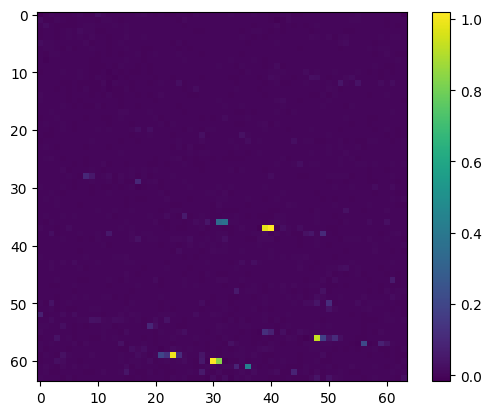

In [142]:
plt.imshow(de_noised.reshape(new_dim))
plt.colorbar()

In [18]:
clean_frames[testEvent].reshape(new_dim)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [33]:
local_maxima, jets_clean = find_local_maxima( clean_frames[testEvent].reshape(new_dim), 9 )

In [34]:
print (local_maxima)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


9


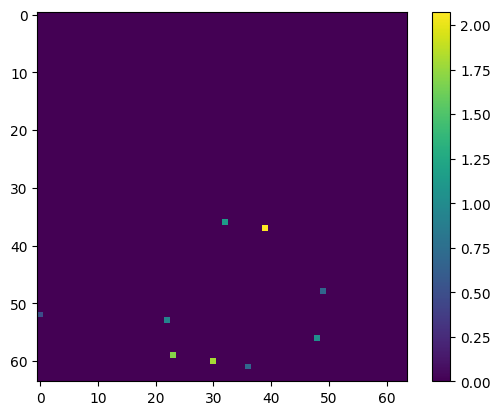

In [35]:
plt.imshow(local_maxima)
print (len(jets_clean))
plt.colorbar()

50


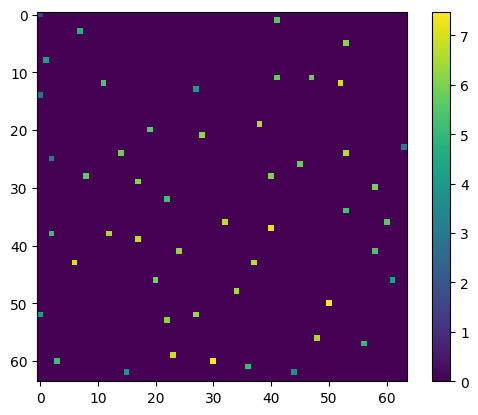

In [36]:
local_maxima, jets_noisy = find_local_maxima( noisy_image.reshape(new_dim), 9 )
print (len(jets_noisy))
plt.imshow(local_maxima)
plt.colorbar()

In [37]:
local_maxima, jets_denoised = find_local_maxima( de_noised.reshape(new_dim), 9 )


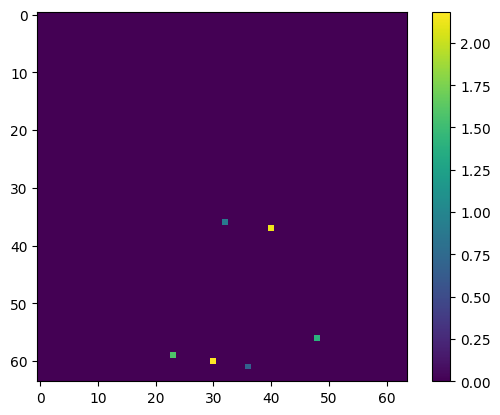

In [38]:
plt.imshow(local_maxima)
plt.colorbar()

In [39]:
print (len(jets_denoised))

6


Reference Maxima: {'i': 36, 'j': 32, 'pixel_value': tensor(0.4899), 'sum_around_maxima': 1.14026}, Test Maxima: {'i': 36, 'j': 32, 'pixel_value': tensor(0.4899), 'sum_around_maxima': 6.738105}
Reference Maxima: {'i': 52, 'j': 0, 'pixel_value': tensor(0.4077), 'sum_around_maxima': 0.49706677}, Test Maxima: {'i': 52, 'j': 0, 'pixel_value': tensor(0.4077), 'sum_around_maxima': 4.094334}
Reference Maxima: {'i': 53, 'j': 22, 'pixel_value': tensor(0.3915), 'sum_around_maxima': 0.9264294}, Test Maxima: {'i': 53, 'j': 22, 'pixel_value': tensor(0.4925), 'sum_around_maxima': 6.1442895}
Reference Maxima: {'i': 56, 'j': 48, 'pixel_value': tensor(0.9369), 'sum_around_maxima': 1.0253941}, Test Maxima: {'i': 56, 'j': 48, 'pixel_value': tensor(0.9807), 'sum_around_maxima': 6.4701867}
Reference Maxima: {'i': 59, 'j': 23, 'pixel_value': tensor(1.), 'sum_around_maxima': 1.7008681}, Test Maxima: {'i': 59, 'j': 23, 'pixel_value': tensor(1.0757), 'sum_around_maxima': 6.7915435}
Reference Maxima: {'i': 60, '

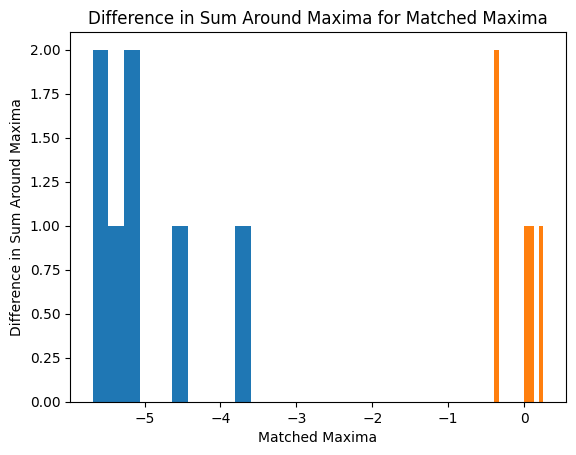

In [46]:
differences_allJetTypes = []
for test_jets in [ jets_noisy, jets_denoised ]:
    matching_jets = find_matching_maxima(jets_clean,test_jets)
    for ref_maxima, test_maxima_entry in matching_jets:
        print(f"Reference Maxima: {ref_maxima}, Test Maxima: {test_maxima_entry}")

    differences = [ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                for ref_maxima, test_maxima_entry in matching_jets]
    differences_allJetTypes.append( differences )

    plt.hist(differences)

plt.xlabel('Matched Maxima')
plt.ylabel('Difference in Sum Around Maxima')
plt.title('Difference in Sum Around Maxima for Matched Maxima')
plt.show()
# # Example usage:
# # Assuming reference_maxima and test_maxima are your lists of maxima positions
# reference_maxima = [...]  # Your list of maxima from the reference
# test_maxima = [...]       # Your list of maxima from the test

# # Find matching maxima
# matching_maxima = find_matching_maxima(reference_maxima, test_maxima)

# # Display the matching maxima
# print("Matching Maxima:")
# for ref_maxima, test_maxima_entry in matching_maxima:
#     print(f"Reference Maxima: {ref_maxima}, Test Maxima: {test_maxima_entry}")

In [91]:
differences_allJetTypes = []

differences_jets_noisy = []
differences_jets_denoised = []
differences_jets_denoised_partial = []

for event in range(100):
    print ("Event : ",event)
    noise_scheduler = NoiseScheduler('pile-up')
    timestep = torch.LongTensor([40]) #each unit of timestep represents an addtional 5 pile-up events
    random_seed = 42

    noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)
    noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0]
    de_noised = noisy_image[0] - (noise_pred.detach().numpy().reshape(new_dim))

    noisy_image_partial, noise_partial = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = 1000)
    noise_pred_partial = model(noisy_image_partial.unsqueeze(1), torch.LongTensor([1]), return_dict=False)[0]
    de_noised_partial = noisy_image_partial[0] - (noise_pred_partial.detach().numpy().reshape(new_dim))


    local_maxima, jets_clean = find_local_maxima( clean_frames[event].reshape(new_dim), 9 )
    local_maxima, jets_noisy = find_local_maxima( noisy_image.reshape(new_dim), 9 )
    local_maxima, jets_denoised = find_local_maxima( de_noised.reshape(new_dim), 9 )
    local_maxima, jets_denoised_partial = find_local_maxima( de_noised_partial.reshape(new_dim), 9 )
    
    matching_jets_noisy = find_matching_maxima(jets_clean,jets_noisy)
    matching_jets_denoised = find_matching_maxima(jets_clean,jets_denoised)
    matching_jets_denoised_partial = find_matching_maxima(jets_clean,jets_denoised_partial)

    differences_jets_noisy.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_noisy])
    differences_jets_denoised.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_denoised])
    differences_jets_denoised_partial.extend([ref_maxima['sum_around_maxima'] - test_maxima_entry['sum_around_maxima']
                    for ref_maxima, test_maxima_entry in matching_jets_denoised_partial])

Event :  0


Event :  1
Event :  2
Event :  3
Event :  4
Event :  5
Event :  6
Event :  7
Event :  8
Event :  9
Event :  10
Event :  11
Event :  12
Event :  13
Event :  14
Event :  15
Event :  16
Event :  17
Event :  18
Event :  19
Event :  20
Event :  21
Event :  22
Event :  23
Event :  24
Event :  25
Event :  26
Event :  27
Event :  28
Event :  29
Event :  30
Event :  31
Event :  32
Event :  33
Event :  34
Event :  35
Event :  36
Event :  37
Event :  38
Event :  39
Event :  40
Event :  41
Event :  42
Event :  43
Event :  44
Event :  45
Event :  46
Event :  47
Event :  48
Event :  49
Event :  50
Event :  51
Event :  52
Event :  53
Event :  54
Event :  55
Event :  56
Event :  57
Event :  58
Event :  59
Event :  60
Event :  61
Event :  62
Event :  63
Event :  64
Event :  65
Event :  66
Event :  67
Event :  68
Event :  69
Event :  70
Event :  71
Event :  72
Event :  73
Event :  74
Event :  75
Event :  76
Event :  77
Event :  78
Event :  79
Event :  80
Event :  81
Event :  82
Event :  83
Event :  84
E

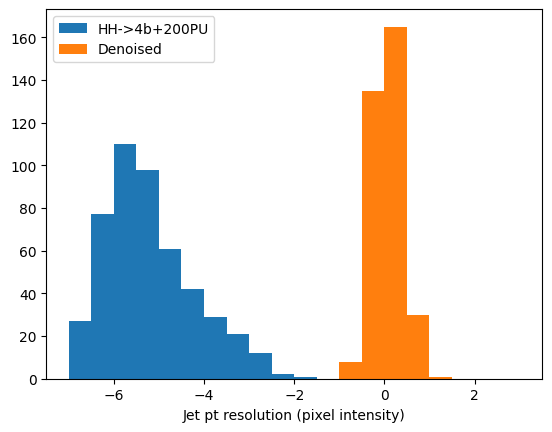

In [98]:
plt.hist(differences_jets_noisy, bins=20, range=(-7,3), label='HH->4b+200PU')#, histtype='step')
# plt.hist(differences_jets_denoised_partial, bins=20, range=(-7,3), label='Partially denoised', histtype='step')
plt.hist(differences_jets_denoised, bins=20, range=(-7,3), label='Denoised')#, histtype='step')
plt.xlabel('Jet pt resolution (pixel intensity)')
plt.legend()


In [90]:
print (differences_jets_denoised)

[0.25608122, -0.37540996, 0.11972427, -0.39109576, 0.009586215, -0.13134003, 0.19615912, -0.12618327, 0.6538769, -0.26399446, -0.3165872, -0.121815085, 0.9123291, -0.41242325, -0.19014573, 0.084931135, 0.04738915, 0.2265594, 0.9442377, 0.23170042, -0.32745516, 0.058836102, 0.014441848, -0.10024035, 0.1034348, -0.22840774, 0.25158072, 0.24729908, 0.2730675, 0.25989604, 0.2688521, 0.016705036, 0.015946865, 0.26562953, 0.52233505, 0.08441877, 0.82518816, 0.19103765, -0.29939377, -0.20816183]
